# Course Project

## Setup

In [1]:
import os
import math
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as sklearn_preprocessing
import tensorflow as tf
import tensorflow.keras as keras
import librosa as lr
import soundfile as sf

In [2]:
dataset = []
sr = 22050//4
for file in os.listdir('audio'):
    data, _ = lr.load(f'./audio/{file}', sr=sr)
    dataset.append(data)
dataset = np.array(dataset, dtype=object)

## Utility functions

In [3]:
def plot_sample(sample):
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(sample.shape[0]), sample)

def plot_samples(samples):
  colors = 'rgbm'
  if len(samples) > 4:
    raise Exception('Нюхай бебру більше 4 графіків не намалюю')
  plt.figure(figsize=(12, 6))
  for i, sample in enumerate(samples):
    plt.plot(np.arange(sample['data'].shape[0]), sample['data'], colors[i], label=sample['label'])
  plt.legend()

In [4]:
def cut_audio(audio, start, length):
  res = np.copy(audio)
  start = int(start * sr)
  length = int(length * sr)
  res[start:start + length] = 0.0
  return res

In [5]:
def get_range(data):
  return (data.min(), data.max())

In [6]:
def restore_audio(audio_data, frequency_range=(0.0, 1.0)):
  return sklearn_preprocessing.minmax_scale(audio_data, feature_range=frequency_range)

In [7]:
def write_audio(filename, audio_data, sample_rate):
  sf.write(filename, audio_data, sample_rate, 'PCM_24')

## Train / validation data preparation

In [8]:
seq_size = sr // 2

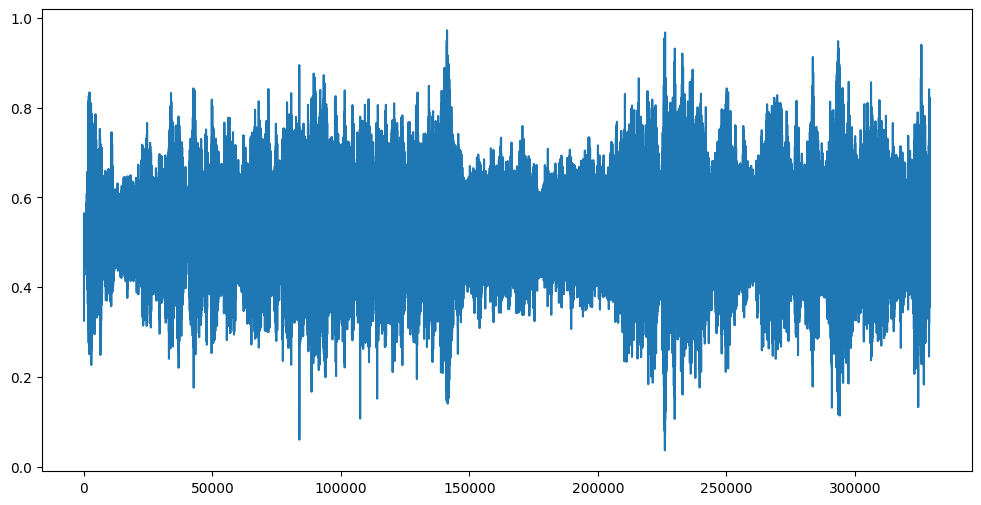

In [9]:
plot_sample(dataset[0])

In [10]:
def sequentialize_sample(sample):
  X = []
  y = []
  for i in range(sample.shape[0]-seq_size-1):
      window = sample[i:(i+seq_size)]
      X.append(window)
      y.append(sample[i+seq_size])

  X = np.array(X)
  X = X.reshape(X.shape[0], 1, X.shape[1])
  y = np.array(y)

  return X, y

In [11]:
def prepare_sample(sample):
  return sequentialize_sample(sample)

In [12]:
sample_duration = 4.0

In [13]:
def cut_samples(dataset):
    samples = []
    for track in dataset:
        track_len = int(track.shape[0] // sr)
        for i in range(0, track_len - math.ceil(sample_duration), math.ceil(sample_duration)):
            start = int(i * sr)
            finish = int(start + sr * sample_duration)
            samples.append(track[start:finish])
    return np.array(samples, dtype=np.float32)

In [39]:
def standardize_dataset(dataset):
    scaler = sklearn_preprocessing.StandardScaler()
    scaled_dataset = scaler.fit_transform(np.expand_dims(dataset.flatten(), axis=-1)).T
    return scaled_dataset, scaler

In [40]:
scaled_dataset, scaler = standardize_dataset(dataset)
samples = cut_samples(scaled_dataset)

## Model training

In [50]:
epochs = 10
batch_size = 32

In [51]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True,
          ), input_shape=(None, seq_size)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()
for i, sample in enumerate(samples[:1]):
    print(f'Fitting sample {i + 1} / {samples.shape[0]}')
    X_train, y_train = prepare_sample(sample)
    print(X_train.shape, y_train.shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=True, validation_split=0.1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirecti  (None, None, 128)        1444352   
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 128)        98816     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_17 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                      

## Test results

In [52]:
cut_duration = 0.5
cut_start = 2.0

In [53]:
def cut_sample(sample):
  sample_cut = np.copy(sample)
  start = cut_start
  if start == None:
    start = random.uniform(0.0, sample_cut.shape[0])
  end = start + cut_duration
  start = int(start * sr)
  end = int(end * sr)
  sample_cut[start:end] = 0.0
  return sample_cut, range(start, end)

In [54]:
def fix_audio(og_audio, cut_audio, cut_range):
    res = np.copy(og_audio)
    res[cut_range] = restore_audio(cut_audio[cut_range], get_range(og_audio)).T[0]
    return res

517/517 [==============================] - 1s 2ms/step


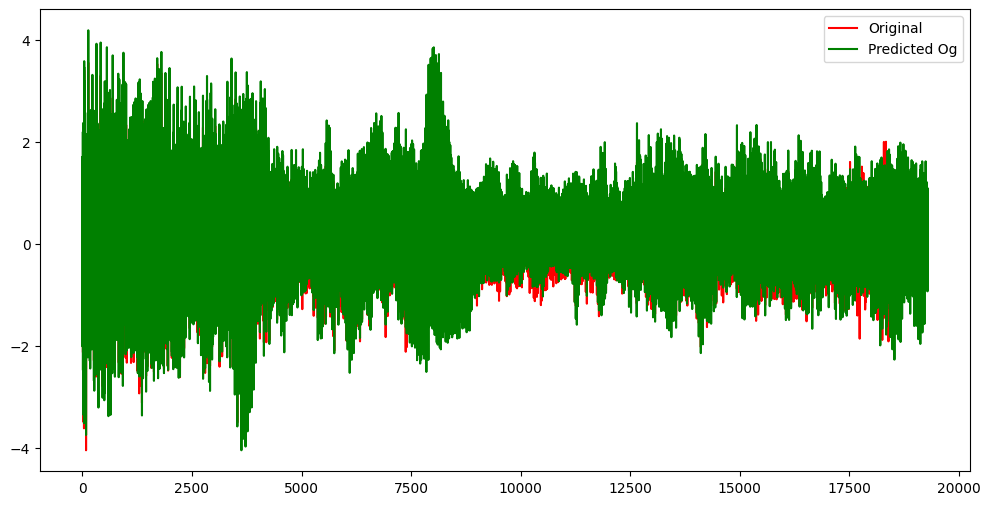

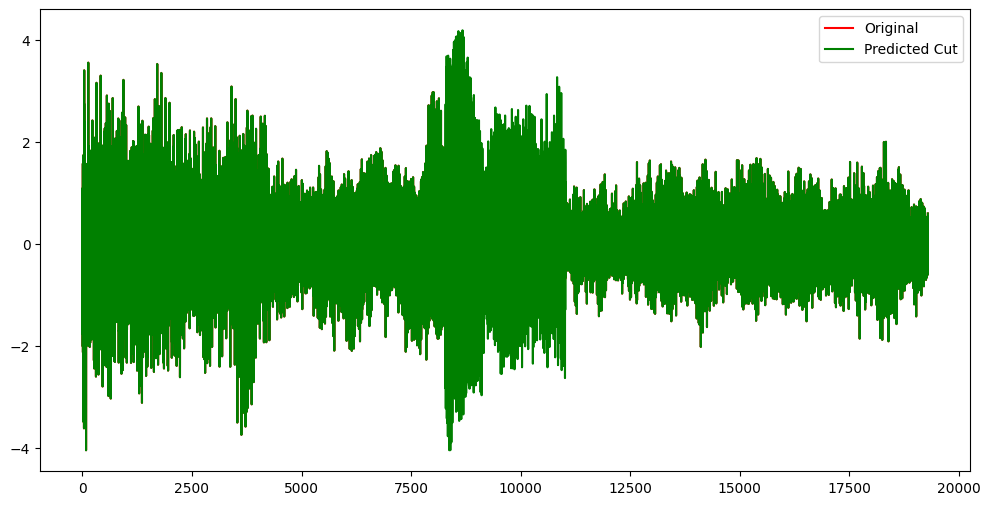

In [55]:
try:
    shutil.rmtree('compare')
except:
    pass  
os.makedirs('compare')

samples_to_plot = [0]
for i in samples_to_plot:
    sample_og = samples[i]
    sample_cut, cut_range = cut_sample(sample_og[seq_size:])
    
    X_test, _ = prepare_sample(sample_og)
    y_pred = model.predict(X_test)
    
    X_test_cut, _ = prepare_sample(sample_cut)
    y_pred_cut = model.predict(X_test_cut)

    og = sample_og[seq_size:]
    cut = sample_cut[seq_size:]
    pred = restore_audio(y_pred, get_range(sample_og))
    pred_cut = fix_audio(sample_og, y_pred_cut, cut_range)[seq_size:]
    
    plot_samples([
        { 'data': og, 'label': 'Original' },
        { 'data': pred, 'label': 'Predicted Og' },
    ])
    plot_samples([
        { 'data': og, 'label': 'Original' },
        { 'data': pred_cut, 'label': 'Predicted Cut' },
    ])

    write_audio(f'compare/{i}_sample_og.wav', og, sr)
    write_audio(f'compare/{i}_sample_cut.wav', cut, sr)
    write_audio(f'compare/{i}_sample_pred.wav', pred, sr)
    write_audio(f'compare/{i}_sample_pred_cut.wav', pred_cut, sr)
    